#### **Dataset Preparation**

In [ ]:
import kagglehub
path = kagglehub.dataset_download("belalakhter/duolingo-app-user-review-play-store-dataset-2025")

100%|██████████| 31.2M/31.2M [00:02<00:00, 13.3MB/s]

Extracting files...


In [ ]:
import os
import pandas as pd

csv_file_path = os.path.join(path, 'duolingo_reviews_2025.csv')
df = pd.read_csv(csv_file_path, low_memory=False)

#### **Exploratory Data Analysis**

In [ ]:
df.head()

,review_id,content,score,thumbs_up_count,created_at
0,3fb9962a-29cc-4f66-a1ba-0bab09f64ff5,i grow fast it's amazing 🤩😍,3,0,2025-12-03T16:12:18.610Z
1,f4a1a549-424e-419c-94ab-c0384dab167b,superb,5,0,2025-12-03T16:12:12.558Z
2,7332250f-4bbd-4d0e-b386-62eeedf3fdc1,superb app,5,0,2025-12-03T16:11:46.348Z
3,e563ec1f-a110-4c61-8fe1-cb7c260d4567,please tell me how to stop my phone from vibra...,4,0,2025-12-03T16:11:02.627Z
4,b30f4801-046f-4315-8bfd-e240ce6483de,Good for learning.And also..don't forget your ...,5,0,2025-12-03T16:10:33.100Z


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504862 entries, 0 to 504861
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   review_id        504862 non-null  object
 1   content          504860 non-null  object
 2   score            504862 non-null  object
 3   thumbs_up_count  504862 non-null  object
 4   created_at       504861 non-null  object
dtypes: object(5)
memory usage: 19.3+ MB


#### **Pre-processing: Data Cleansing**

In [ ]:
# Drop kolom yang tidak diperlukan
df = df.drop(columns=['review_id', 'thumbs_up_count', 'created_at'])

In [ ]:
# Ubah tipe data kolom score menjadi numerik
df['score'] = pd.to_numeric(df['score'], errors='coerce')

In [ ]:
# Drop data NaN
df = df.dropna(subset=['content'])
df = df.dropna(subset=['score'])

In [ ]:
# Cleaning data review yang memiliki whitespace berlebih (double spasi atau lebih)
def clean_whitespace(text):
    return " ".join(text.split())

df['content'] = df['content'].apply(clean_whitespace)

In [ ]:
# Rename kolom "content" menjadi "text" agar sesuai dengan standar huggingface
df = df.rename(columns={'content': 'text'})

#### **Pre-processing: Feature Engineering**

In [ ]:
# Mengonversi score (1-5) menjadi kategori sentimen:
# 1-2: Negative, 3: Neutral, 4-5: Positive

def label(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['score'].apply(label)

In [ ]:
# Convert sentiment jadi label numerik
label_mapping = {
    'Negative': 0,
    'Neutral':  1,
    'Positive': 2
}

df['label'] = df['sentiment'].map(label_mapping)

In [ ]:
df.head()

,text,score,sentiment,label
0,i grow fast it's amazing 🤩😍,3.0,Neutral,1
1,superb,5.0,Positive,2
2,superb app,5.0,Positive,2
3,please tell me how to stop my phone from vibra...,4.0,Positive,2
4,Good for learning.And also..don't forget your ...,5.0,Positive,2


#### **Pre-processing: Data Balancing**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Data positive terlalu banyak sehingga harus membagi data menjadi 2 : 1.5 : 1 ratio
sentiment_unique = df['sentiment'].value_counts()
print(sentiment_unique)

sentiment
Positive    403668
Negative     76550
Neutral      24622
Name: count, dtype: int64


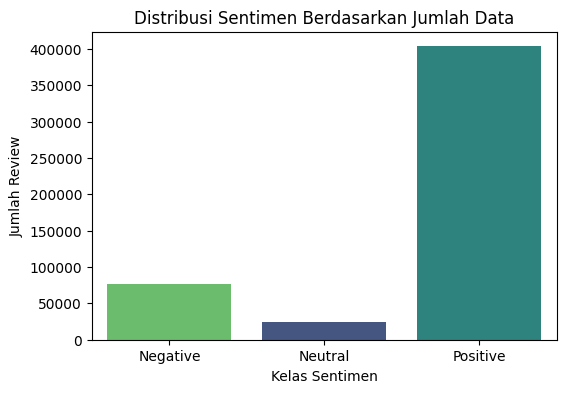

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(
    x='sentiment',
    data=df,
    palette='viridis',
    order=['Negative', 'Neutral', 'Positive'],
    hue='sentiment',
    legend=False
)

plt.title('Distribusi Sentimen Berdasarkan Jumlah Data')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

In [ ]:
from sklearn.utils import resample

df_pos = df[df['sentiment'] == 'Positive']
df_neg = df[df['sentiment'] == 'Negative']
df_neu = df[df['sentiment'] == 'Neutral']

df_pos_resampled = resample(df_pos,
                            replace=False,
                            n_samples=100000,
                            random_state=42)

df_neu_resampled = resample(df_neu,
                            replace=True,
                            n_samples=50000,
                            random_state=42)

df = pd.concat([df_pos_resampled, df_neg, df_neu_resampled])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

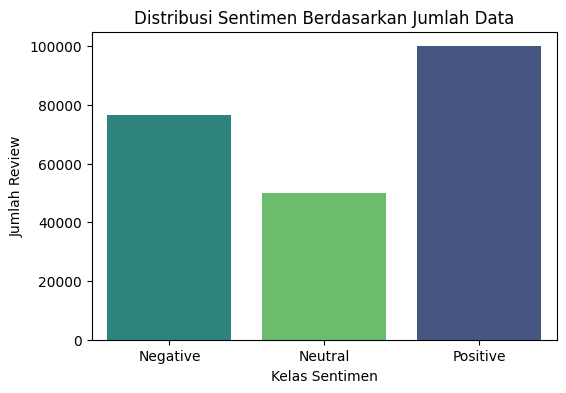

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(
    x='sentiment',
    data=df,
    palette='viridis',
    order=['Negative', 'Neutral', 'Positive'],
    hue='sentiment',
    legend=False
)

plt.title('Distribusi Sentimen Berdasarkan Jumlah Data')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

#### **Model Training**

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")

In [ ]:
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label'].tolist()
)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

In [ ]:
model_checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/181240 [00:00<?, ? examples/s]

Map:   0%|          | 0/45310 [00:00<?, ? examples/s]

In [ ]:
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./duolingo-sentiment-analysis-bert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    fp16=True
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.616000,0.562661,0.779563,0.768270
2,0.520100,0.537771,0.800110,0.796956
3,0.435700,0.542273,0.811432,0.808118


TrainOutput(global_step=33984, training_loss=0.5239092580791697, metrics={'train_runtime': 5077.414, 'train_samples_per_second': 107.086, 'train_steps_per_second': 6.693, 'total_flos': 3.576500687176704e+16, 'train_loss': 0.5239092580791697, 'epoch': 3.0})

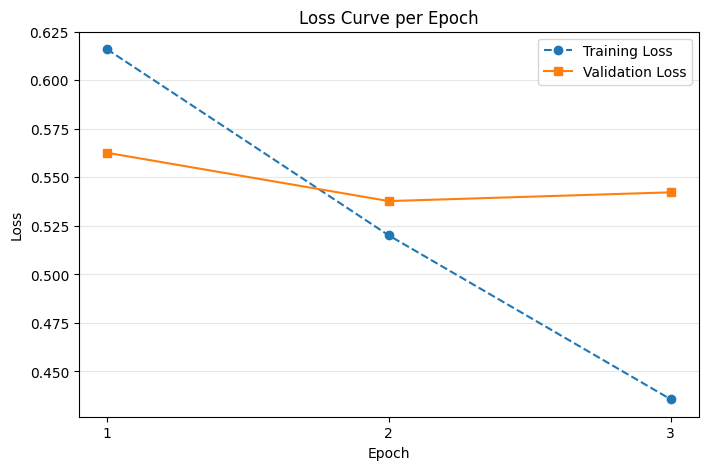

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

epochs = []
train_loss_at_epoch = []
val_loss_at_epoch = []

for log in history:
    if 'eval_loss' in log:
        epochs.append(log['epoch'])
        val_loss_at_epoch.append(log['eval_loss'])

train_loss_all = [log['loss'] for log in history if 'loss' in log]
if len(train_loss_all) >= len(val_loss_at_epoch):
    indices = [int(len(train_loss_all)/len(val_loss_at_epoch) * i) - 1 for i in range(1, len(val_loss_at_epoch) + 1)]
    train_loss_at_epoch = [train_loss_all[i] for i in indices]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_at_epoch, label='Training Loss', marker='o', linestyle='--')
plt.plot(epochs, val_loss_at_epoch, label='Validation Loss', marker='s', linestyle='-')
plt.xticks(epochs)
plt.title('Loss Curve per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

#### **Model Checkpoint Path**

In [ ]:
model_checkpoint_finetuned = "/content/duolingo-sentiment-analysis-bert/checkpoint-33984"

#### **Uji Model**

In [ ]:
from transformers import pipeline

my_classifier = pipeline("sentiment-analysis", model=model_checkpoint_finetuned)

text = "I hate the fact that duolingo used AI in their apps now"
result = my_classifier(text)

print(result)

The tokenizer you are loading from '/content/duolingo-sentiment-analysis-bert/checkpoint-33984' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


[{'label': 'Negative', 'score': 0.9406371712684631}]


#### **Evaluasi Model**

In [ ]:
import logging
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore", category=SyntaxWarning)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

print(f"Load model from checkpoint: {model_checkpoint_finetuned}")

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_finetuned, num_labels=3)

try:
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_finetuned, fix_mistral_regex=True)
except TypeError:
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_finetuned)

training_args = TrainingArguments(
    output_dir="/tmp/pred_output",
    report_to="none",
    do_train=False,
    do_eval=False,
    do_predict=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    processing_class=tokenizer
)

Load model from checkpoint: /content/duolingo-sentiment-analysis-bert/checkpoint-33984


In [ ]:
if 'tokenized_val' in locals():
    output_prediksi = trainer.predict(tokenized_val)

    y_pred = np.argmax(output_prediksi.predictions, axis=1)
    y_true = output_prediksi.label_ids

    target_names = ["Negative", "Neutral", "Positive"]

    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
else:
    print("Error: Variabel 'tokenized_val' tidak ditemukan. Pastikan sudah menjalankan tahap tokenisasi sebelumnya.")

              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85     15310
     Neutral       0.69      0.60      0.64     10000
    Positive       0.81      0.92      0.86     20000

    accuracy                           0.81     45310
   macro avg       0.80      0.78      0.78     45310
weighted avg       0.81      0.81      0.81     45310



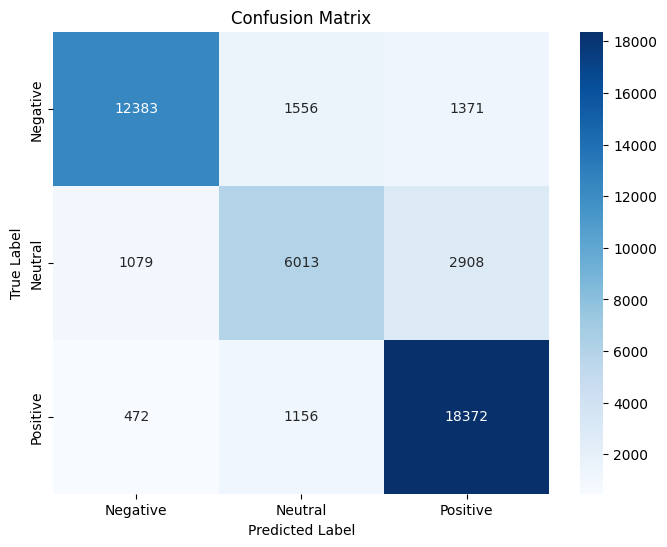

In [ ]:
if 'cm' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix')
    plt.show()
else:
    print("Error: Variabel 'cm' tidak ditemukan. Pastikan sudah menjalankan tahap tokenisasi sebelumnya.")

#### **Visualisasi Word Cloud**

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

my_stopwords = set(STOPWORDS)
my_stopwords.update(["app", "duolingo", "application", "use", "using", "phone"])

def generate_wordcloud(data, title, bgcolor='white', colormap='viridis'):
    text_combined = " ".join(str(t) for t in data)

    if not text_combined.strip():
        print(f"Data untuk {title} kosong/tidak cukup.")
        return

    wc = WordCloud(
        width=800,
        height=400,
        background_color=bgcolor,
        stopwords=my_stopwords,
        colormap=colormap,
        min_font_size=10
    ).generate(text_combined)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15, pad=20)
    plt.show()

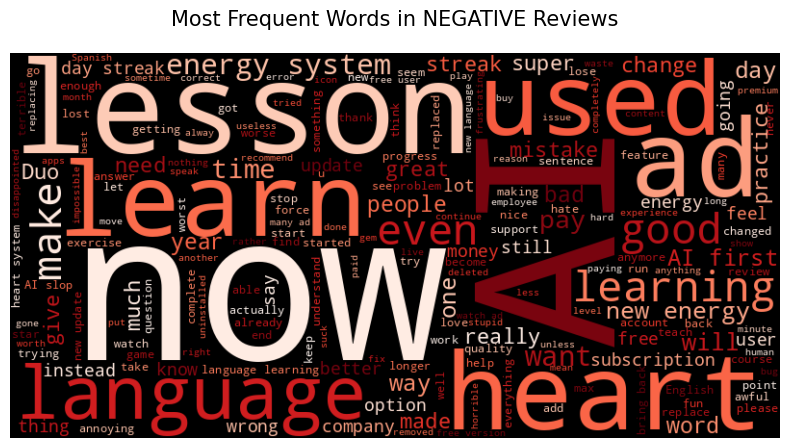

In [ ]:
df_neg = df[df['label'] == 0]
generate_wordcloud(df_neg['text'], "Most Frequent Words in NEGATIVE Reviews", bgcolor='black', colormap='Reds')

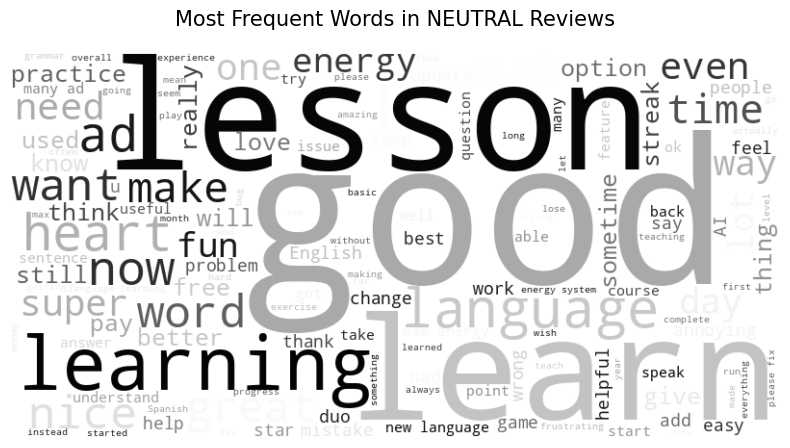

In [ ]:
df_neu = df[df['label'] == 1]
generate_wordcloud(df_neu['text'], "Most Frequent Words in NEUTRAL Reviews", bgcolor='white', colormap='Greys')

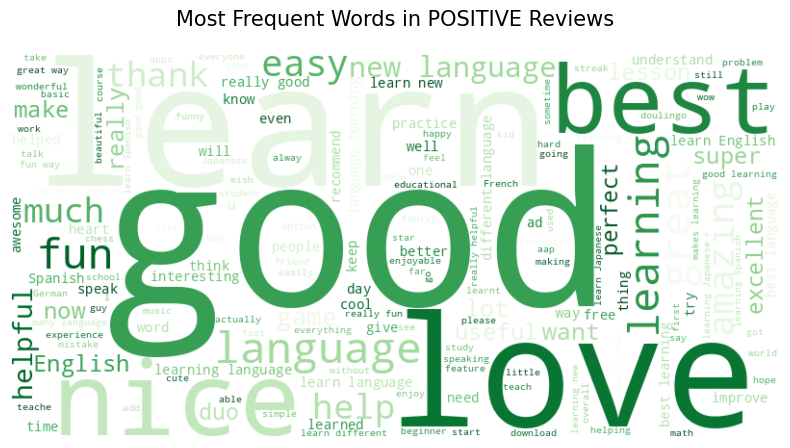

In [ ]:
df_pos = df[df['label'] == 2]
generate_wordcloud(df_pos['text'], "Most Frequent Words in POSITIVE Reviews", bgcolor='white', colormap='Greens')

#### **Upload Model ke File Host (Backup)**

In [ ]:
!zip -r "{model_checkpoint_finetuned.split('/')[-1]}.zip" "{model_checkpoint_finetuned}"

  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/ (stored 0%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/model.safetensors (deflated 7%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/scheduler.pt (deflated 62%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/trainer_state.json (deflated 65%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/rng_state.pth (deflated 26%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/tokenizer.json (deflated 67%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/config.json (deflated 55%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/special_tokens_map.json (deflated 42%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/tokenizer_config.json (deflated 75%)
  adding: content/duolingo-sentiment-analysis-bert/checkpoint-33984/optimizer.pt (deflated 46%)
  adding: content/duoli

In [ ]:
import requests

folder_name = os.path.basename(model_checkpoint_finetuned.rstrip('/'))
file_path = f"/content/{folder_name}.zip"

url = 'https://upload.gofile.io/uploadfile'

with open(file_path, 'rb') as f:
    files = {'file': f}

    print(f"Now uploading: {file_path}")
    response = requests.post(url, files=files)

if response.status_code == 200:
    data = response.json()
    if data['status'] == 'ok':
        download_page = data['data']['downloadPage']
        print("Success: File Uploaded")
        print(download_page)
    else:
        print(f"Gagal: {data['status']}")
else:
    print(f"Terjadi kesalahan HTTP: {response.status_code}")

Now uploading: /content/checkpoint-33984.zip
Success: File Uploaded
https://gofile.io/d/SYx3HA
